# Analysis of energy consumption and records from AB "Šiaulių Energija"

## 1. Setup

In [ ]:
import gdown

url = "https://drive.google.com/uc?export=download&id=1HfJ4P1OELBuToQHB0dh7acJDjGG4IyNq"
output_path = "csv_files/register.csv"
gdown.download(url, output_path, quiet=False)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

register = pd.read_csv("csv_files/register.csv")
rooms = pd.read_csv("csv_files/rooms.csv")

## 2. Feature Engineering

Geometry data is in LKS94 format, which is relatively obscure and hard to work with, therefore we convert it to standard WGS84

In [2]:
from pyproj import Transformer

transformer = Transformer.from_crs('epsg:3346', 'epsg:4326', always_xy=True)
rooms['x_coord'], rooms['y_coord'] = transformer.transform(rooms['x_coord'].values, rooms['y_coord'].values)

In [3]:
register["month"] = pd.to_datetime(register["month"])
rooms["build_year"] = pd.to_datetime(rooms["build_year"])

start_date = pd.to_datetime('2019-01-01')
end_date = pd.to_datetime('2024-12-31')

register = register[(register["month"] >= start_date) & (register["month"] <= end_date)]

In [4]:
joined_df = pd.merge(register, rooms, on="room_id", how="left")

## 3. Exploratory Data Analysis

In [5]:
monthly_result_sum = register.pivot_table(index='month', columns='service_category', values='amount', aggfunc='sum').reset_index()

Very little data is missing, which is very good

In [6]:
register.isna().sum(), rooms.isna().sum()

(room_id             403
 month                 0
 amount                0
 unit                  0
 buyer_id              0
 legal_entity          0
 service_name          0
 service_category      0
 dtype: int64,
 room_id               0
 building_id           0
 room_area          2388
 build_year            9
 building_floors       0
 building_type         0
 building_func         0
 x_coord               3
 y_coord               3
 dtype: int64)

In [7]:
joined_df.isna().sum()

room_id               403
month                   0
amount                  0
unit                    0
buyer_id                0
legal_entity            0
service_name            0
service_category        0
building_id           405
room_area           37716
build_year            569
building_floors       405
building_type         405
building_func         405
x_coord               501
y_coord               501
dtype: int64

In [8]:
register.dtypes, rooms.dtypes

(room_id                     object
 month               datetime64[ns]
 amount                     float64
 unit                        object
 buyer_id                    object
 legal_entity                  bool
 service_name                object
 service_category            object
 dtype: object,
 room_id                    object
 building_id                object
 room_area                 float64
 build_year         datetime64[ns]
 building_floors           float64
 building_type              object
 building_func              object
 x_coord                   float64
 y_coord                   float64
 dtype: object)

In [9]:
register.nunique(), rooms.nunique()

(room_id               44886
 month                    70
 amount              1908729
 unit                      5
 buyer_id              56271
 legal_entity              2
 service_name             12
 service_category          8
 dtype: int64,
 room_id            47734
 building_id         1421
 room_area           6918
 build_year           108
 building_floors       12
 building_type         40
 building_func         16
 x_coord             1416
 y_coord             1416
 dtype: int64)

In [10]:
reg_filt_heat = register[register["service_category"] == "Šiluma"]
reg_filt_heat = pd.DataFrame(reg_filt_heat.groupby("month")["amount"].sum())

reg_filt_wat = register[register["service_category"] == "Karštas vanduo"]
reg_filt_wat = pd.DataFrame(reg_filt_wat.groupby("month")["amount"].sum())

Text(0.5, 1.0, 'Heat over time')

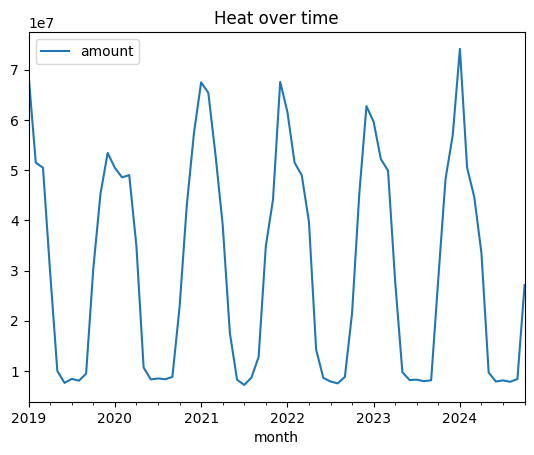

In [11]:
reg_filt_heat.plot()
plt.title("Heat over time")

(0.0, 80000.0)

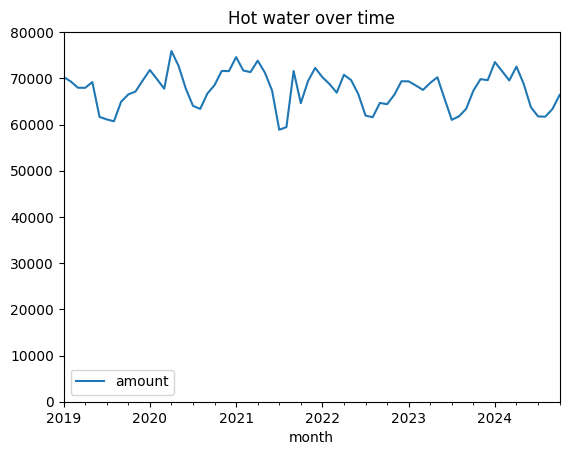

In [12]:
reg_filt_wat.plot()
plt.title("Hot water over time")
plt.ylim(0, 80000)

In [13]:
new_register = register
new_register["year"] = new_register["month"].dt.year.astype(int)
yearly_result_sum = register.pivot_table(index='year', columns='service_category', values='amount', aggfunc='sum').reset_index()

In [14]:
reg_filt_heat = register[register["service_category"] == "Šiluma"]
reg_filt_heat["year"] = reg_filt_heat["month"].dt.year
reg_filt_heat = reg_filt_heat.groupby("year")["amount"].sum().reset_index()
reg_filt_heat.set_index("year", inplace=True)

reg_filt_wat = register[register["service_category"] == "Karštas vanduo"]
reg_filt_wat["year"] = reg_filt_wat["month"].dt.year
reg_filt_wat = reg_filt_wat.groupby("year")["amount"].sum().reset_index()
reg_filt_wat.set_index("year", inplace=True)

C:\Users\zygim\AppData\Local\Temp\ipykernel_9636\982236684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_filt_heat["year"] = reg_filt_heat["month"].dt.year
C:\Users\zygim\AppData\Local\Temp\ipykernel_9636\982236684.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_filt_wat["year"] = reg_filt_wat["month"].dt.year


Text(0.5, 1.0, 'heat consumption by year')

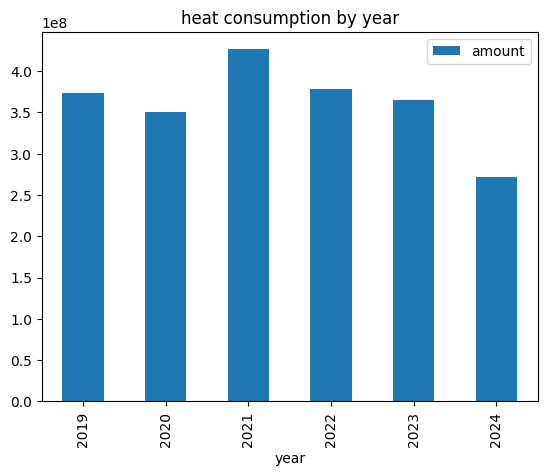

In [15]:
reg_filt_heat.plot(kind="bar")
plt.title("heat consumption by year")

Text(0.5, 1.0, 'water consumption by year')

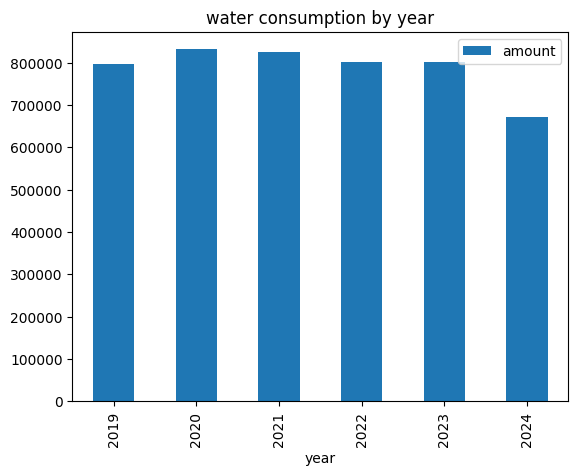

In [16]:
reg_filt_wat.plot(kind="bar")
plt.title("water consumption by year")


Text(0.5, 1.0, 'Total number of rooms that have contracts (registered)')

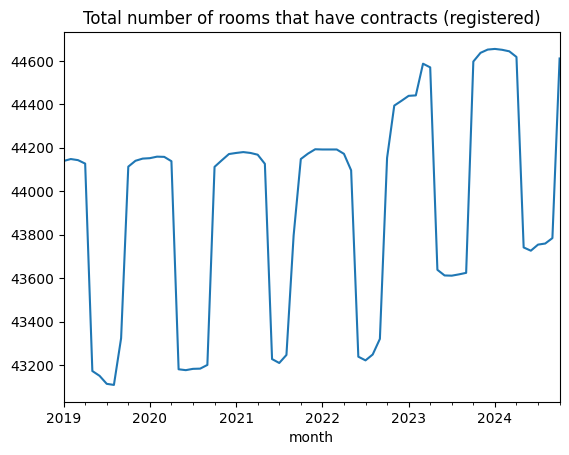

In [17]:
grouped = register.groupby("month")["room_id"].nunique()
grouped.plot()
plt.title("Total number of rooms that have contracts (registered)")

In [18]:
new_register = register
new_register["year"] = new_register["month"].dt.year.astype(int)
grouped = new_register.groupby("year").size()

Text(0.5, 1.0, 'Total number of contracts')

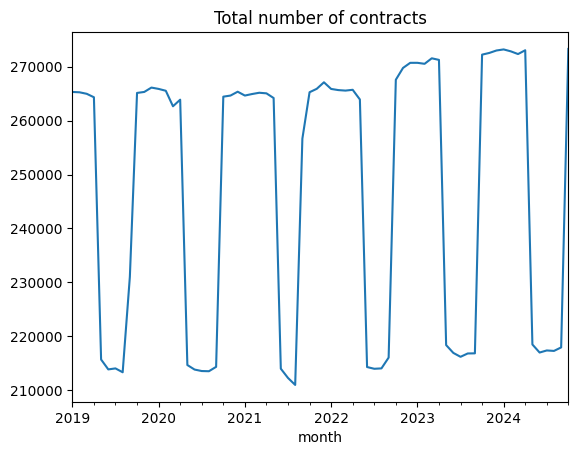

In [19]:
grouped = register.groupby("month").size()
grouped.plot()
plt.title("Total number of contracts")

Text(0.5, 1.0, 'Total number of buildings that have contracts')

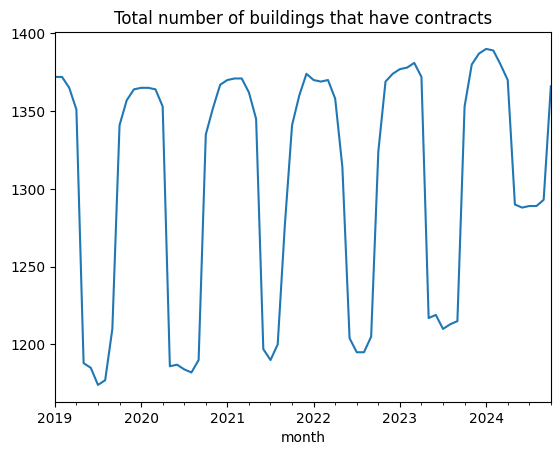

In [21]:
grouped = joined_df.groupby("month")["building_id"].nunique()
grouped.plot()
plt.title("Total number of buildings that have contracts")

### Energy consumed per building function

In [22]:
rooms["building_func"].value_counts()

building_func
Gyvenamasis (trijų ir daugiau butų - daugiaaukštis pastatas)    47079
Administracinė                                                    266
Mokslo                                                            119
Prekybos                                                           67
Gydymo                                                             48
Gyvenamasis (individualus pastatas)                                47
Kultūros                                                           24
Gamybos                                                            19
Sporto                                                             18
Kita                                                               14
Transporto                                                         11
Viešbučių                                                           5
Sandėliavimo                                                        5
Komercinės paskirties                                               5
Religi

From the value counts above I can only think that either the dataset is not complete, because there is only 47 room id for individual buildings?

In [23]:
filtered_df = joined_df[joined_df["service_category"] == "Karštas vanduo"]
filtered_df["building_func"].fillna("Nezinoma", inplace=True)
filtered_df["year"] = filtered_df["month"].dt.year.astype(int)
pivot_df = filtered_df.pivot_table(values="amount", index="year", columns="building_func", aggfunc="sum", fill_value=0)
col_order = pivot_df.sum().sort_values(ascending=False).index
pivot_df = pivot_df[col_order]
pivot_df

C:\Users\zygim\AppData\Local\Temp\ipykernel_9636\1457825724.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df["building_func"].fillna("Nezinoma", inplace=True)
C:\Users\zygim\AppData\Local\Temp\ipykernel_9636\1457825724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["building_func"].fillna("Nezinoma", inplace=Tru

building_func,Gyvenamasis (trijų ir daugiau butų - daugiaaukštis pastatas),Mokslo,Kita,Administracinė,Gyvenamasis (individualus pastatas)
year,,,,,
2019,791759.923800,2847.0,942.61,662.150,24.5
2020,826845.245000,2663.0,1419.34,533.860,29.5
2021,821265.966614,2994.0,1413.60,511.620,27.0
2022,796902.099131,2879.0,493.45,910.490,28.5
2023,800642.511759,1435.0,60.00,846.114,28.0
2024,671716.400860,356.0,54.00,755.655,21.0


<Axes: xlabel='year'>

<Figure size 1000x600 with 0 Axes>

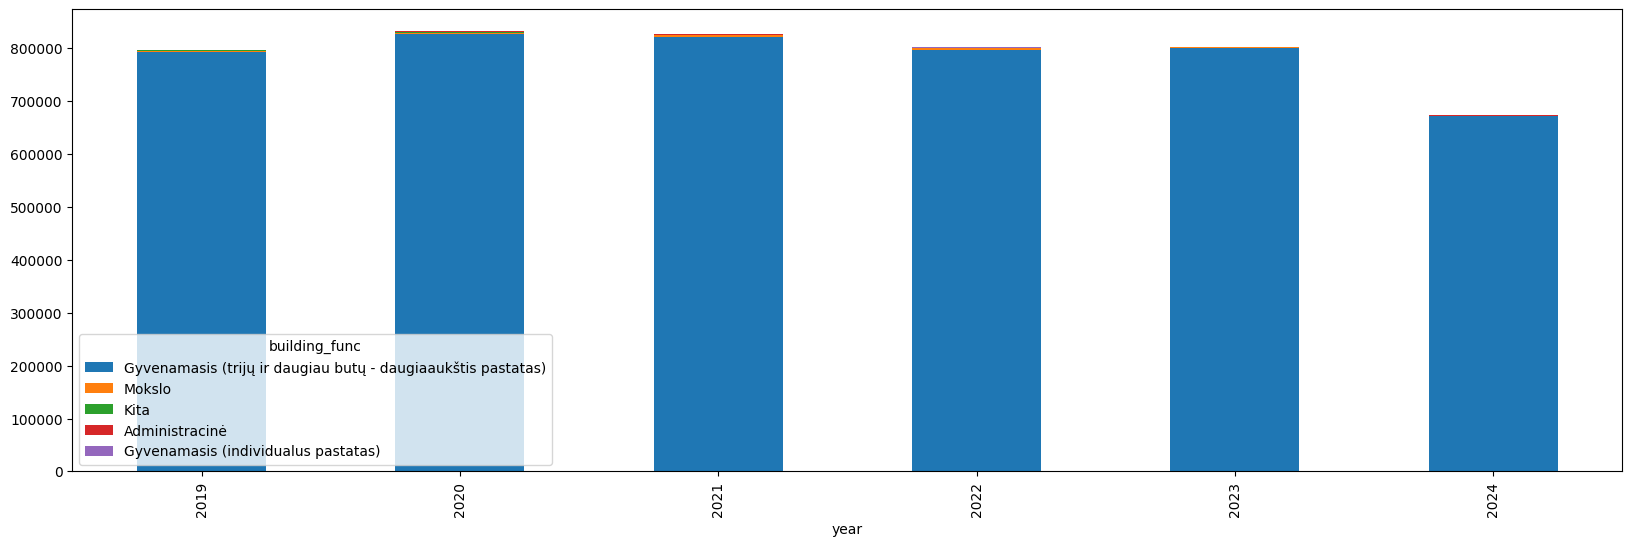

In [24]:
plt.figure(figsize=(10, 6))
pivot_df.plot(kind="bar", stacked=True, legend=True, figsize=(20, 6))

<Axes: xlabel='year'>

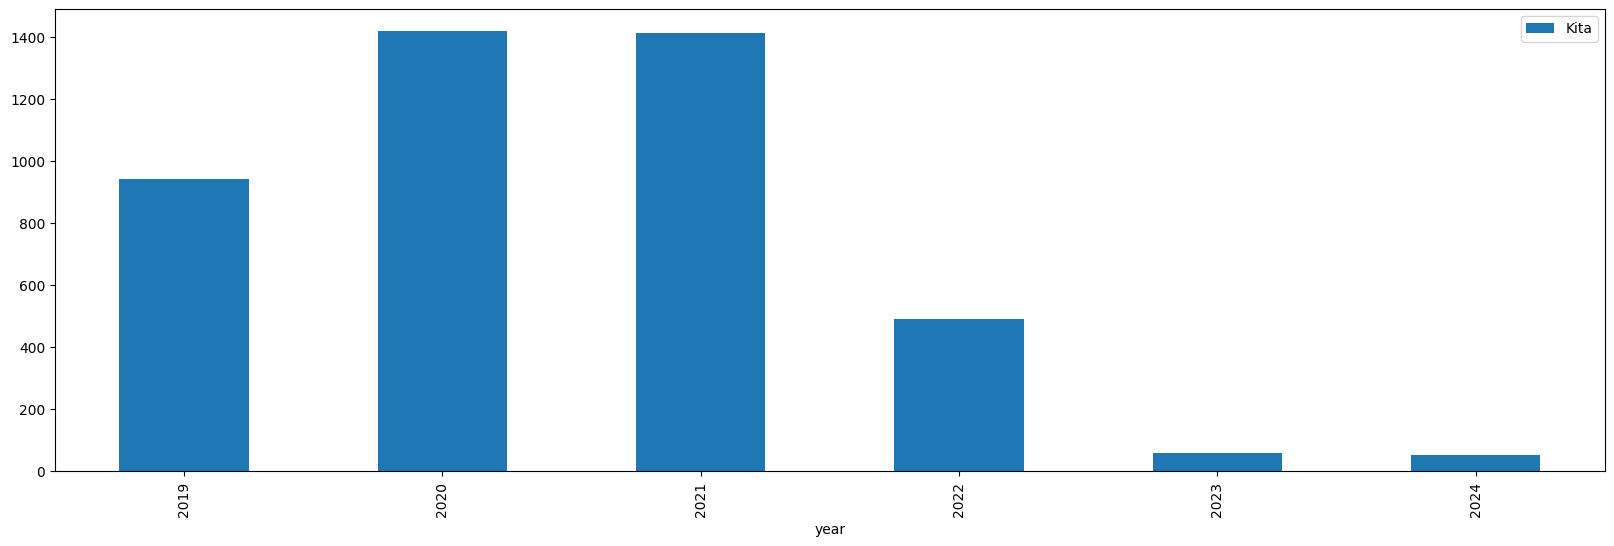

In [28]:
pivot_df["Kita"].plot(kind="bar", legend=True, figsize=(20, 6))

In [29]:
# avg rooms per buyer id

buyer_room_df = register.groupby("buyer_id")["room_id"].nunique()
buyer_room_df = buyer_room_df[buyer_room_df != 0]

In [ ]:
buyer_room_df = buyer_room_df.sort_values(ascending=False).head(50)
buyer_room_df

buyer_id
450afdfda068aa0    664
d63d13cf5c8f252    228
d39fb998724eb94     99
30e5567877c6263     50
7ba7ac85ee8ba1c     46
f401cfddff767f7     39
42c7d838c91dd9e     35
95c37810b5309ce     33
fea7a8dbfcd51e5     32
d7a1278f09be5e8     32
5fb3d17954838b2     26
fe42721de77106c     23
a50e56668bc91c8     20
dca1971e3be2f7c     18
c588767a9a0782c     16
f17a4ac8b7f0d6c     15
e3694f57063826a     14
72d441ca0c574f5     14
46f4708d23666fd     13
f3581f8b7ec8481     12
3a18c414b784056     12
f575399b53a20a0     12
22218b895be665b     11
28b562ecacd0089     11
ffbe7a01a899180     11
6a0bdbc99dd62f5     10
dc2abf87bc904b0     10
b0c1e266a80cce0     10
b20688098ef5a78      9
b5afb808886996f      9
99327630ced45c6      9
90ad395b9b1ed7b      8
132e50f118c9553      8
a5e49f5e6d8cdd1      8
12de6eca4a6734f      8
ace49af8efbdb51      7
8af8c85bb1e8488      7
06e03558820317c      7
0c3641ae23fe303      7
f1a528ab8ab54ca      6
86a5ffefa180731      6
b3ad9def5c3c59a      6
447278ea4922c10      6
64

In [32]:
rooms["y_coord"].max() - rooms["y_coord"].min()

0.5874351859650844

In [ ]:
# Geospatial
filtered_df = joined_df[joined_df["service_category"] == "Karštas vanduo"]
filtered_df = filtered_df[["month", "amount", "x_coord", "y_coord"]]
filtered_df.dropna(inplace=True)

grid_size = 0.0001

# Create new columns for the grid coordinates
filtered_df['x_grid'] = (filtered_df['x_coord'] // grid_size) * grid_size
filtered_df['y_grid'] = (filtered_df['y_coord'] // grid_size) * grid_size

# Group by the grid coordinates and sum the amounts
aggregated_df = filtered_df.groupby(["month", 'x_grid', 'y_grid']).agg({'amount': 'sum'}).reset_index()
aggregated_df

,month,x_grid,y_grid,amount
0,2019-01-01,22.9255,55.9890,32.461
1,2019-01-01,22.9255,55.9914,1.500
2,2019-01-01,22.9365,56.0032,2.603
3,2019-01-01,22.9370,56.0027,5.192
4,2019-01-01,22.9389,56.0044,3.600
...,...,...,...,...
62942,2024-10-01,23.4233,55.9224,30.860
62943,2024-10-01,23.4233,55.9228,30.300
62944,2024-10-01,23.4237,55.9210,27.400
62945,2024-10-01,23.4243,55.9215,16.268


In [ ]:
# geospatial building age data
builds = rooms.groupby("building_id").first()[["build_year", "x_coord", "y_coord"]].reset_index(drop=True)
builds.dropna(inplace=True)
builds["build_year"] = builds["build_year"].dt.year.astype(int)
builds.head()

,build_year,x_coord,y_coord
0,1981,23.303358,55.934346
1,1984,22.951034,55.987235
2,1937,23.315403,55.932877
3,2007,23.309599,55.928946
4,1900,23.274152,55.906005


In [ ]:
# geospatial building floor data
builds = rooms.groupby("building_id").first()[["building_floors", "x_coord", "y_coord"]].reset_index(drop=True)
builds.dropna(inplace=True)
builds.head()

,building_floors,x_coord,y_coord
0,5.0,23.303358,55.934346
1,5.0,22.951034,55.987235
2,3.0,23.315403,55.932877
3,13.0,23.309599,55.928946
4,1.0,23.274152,55.906005


0           1965.0
1           1963.0
2           1967.0
3           1969.0
4           1961.0
             ...  
17315985    1992.0
17315986    1989.0
17315987    1964.0
17315988    1969.0
17315989    1987.0
Name: build_year, Length: 17315990, dtype: float64

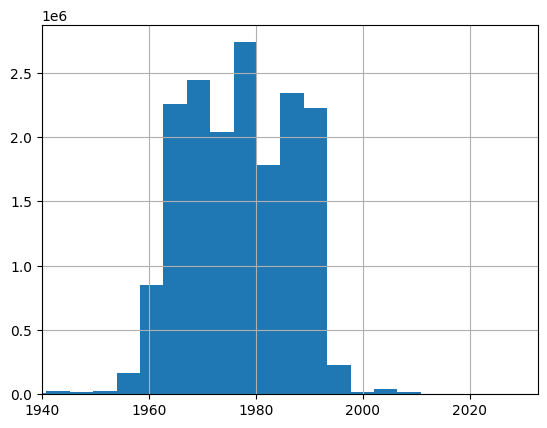

In [36]:
years = joined_df["build_year"]
years = years.dt.year
years.hist(bins=40)
plt.xlim(1940)
years

In [37]:
filtered_df = joined_df[joined_df["service_category"] == "Šiluma"]
filtered_df = filtered_df.groupby(["room_id", "month"])["amount"].sum().reset_index()
filtered_df = filtered_df.groupby("room_id")["amount"].mean().reset_index()

In [38]:
merged_df = pd.merge(filtered_df, rooms[["room_id", "room_area", "build_year", "building_func"]], on="room_id", how="left")
merged_df = merged_df[merged_df["room_area"] > 1]
merged_df["eff"] = merged_df["amount"] / merged_df["room_area"]
merged_df["build_year"] = merged_df["build_year"].dt.year
merged_df

,room_id,amount,room_area,build_year,building_func,eff
0,0000f5a306aa85a,596.872841,50.10,1987.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,11.913630
1,0003b5d9f0dca41,610.152813,45.85,1966.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,13.307586
2,00044f4c89baa63,321.933291,17.78,1973.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,18.106484
3,0005b1cb5c56b3f,674.913960,36.24,1982.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,18.623454
4,0006d206de1f4df,188.756661,18.70,1972.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,10.093939
...,...,...,...,...,...,...
44835,fffa5db39533088,416.538259,36.13,1983.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,11.528875
44836,fffb874c4de8366,831.716616,65.54,1985.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,12.690214
44837,fffbb9a4a3e62b7,579.197359,50.62,1981.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,11.442066
44838,fffdcb94cc425f1,342.482600,43.12,1962.0,Gyvenamasis (trijų ir daugiau butų - daugiaauk...,7.942546


In [39]:
area_df = merged_df[merged_df["room_area"] < 120]
area_df = area_df[["room_area", "eff"]].sort_values(by="room_area")
area_df["area_bins"] = pd.cut(area_df["room_area"], bins=[0, 20, 40, 60, 80, 100, 120], labels=["0-20", "21-40", "41-60", "61-80", "81-100", "101-120"])
area_df = area_df.groupby("area_bins")["eff"].mean().reset_index()
#area_df.to_csv("area_df.csv")

C:\Users\zygim\AppData\Local\Temp\ipykernel_9636\1434966582.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  area_df = area_df.groupby("area_bins")["eff"].mean().reset_index()


<Axes: >

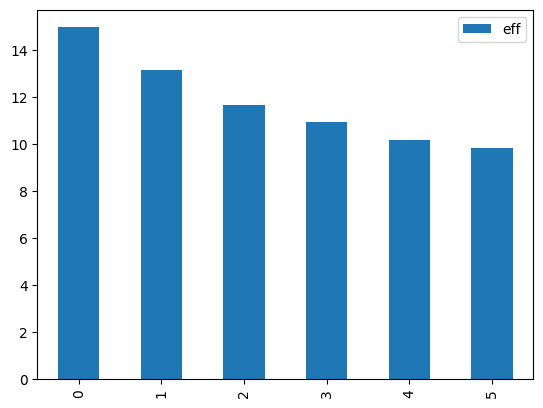

In [40]:
area_df.plot(kind="bar")

In [41]:
func_df = merged_df.groupby("building_func")["eff"].mean().sort_values(ascending=False)
#func_df.to_csv("func_df.csv")
func_df

building_func
Transporto                                                      33.172033
Maitinimo                                                       20.305455
Gyvenamasis (individualus pastatas)                             15.982357
Religinės                                                       14.880119
Kita                                                            14.418169
Gydymo                                                          14.341770
Administracinė                                                  13.624995
Kultūros                                                        13.324165
Gamybos                                                         12.631251
Prekybos                                                        12.159059
Gyvenamasis (trijų ir daugiau butų - daugiaaukštis pastatas)    11.909166
Sporto                                                          10.928788
Mokslo                                                           8.730434
Viešbučių               

Buildings are limited from 1900 to 2019 because the sample size is way too small to get an accurate average heat consumption

<Axes: xlabel='build_year'>

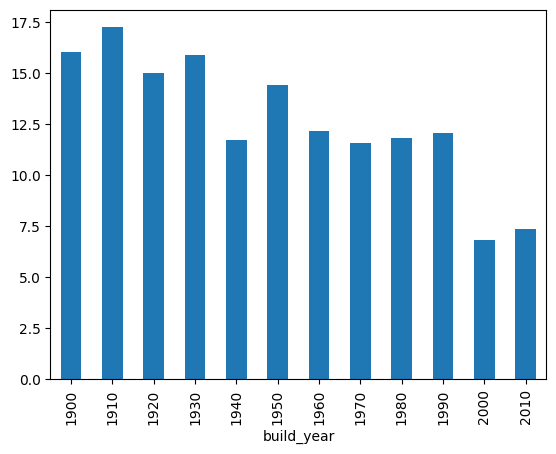

In [42]:
grouped_df = merged_df
grouped_df = grouped_df[grouped_df["build_year"] >= 1900]
grouped_df = grouped_df[grouped_df["build_year"] <= 2019]
grouped_df["build_year"] = grouped_df["build_year"] // 10 * 10
grouped_df["build_year"] = grouped_df["build_year"].astype("Int64")
grouped_df = grouped_df.groupby("build_year")["eff"].mean()
grouped_df.plot(kind="bar")
#grouped_df.to_csv("heat_by_build_year.csv")

In [43]:
# Obviously a room can't have an area of 0 so I'm removing those

new_rooms = rooms[rooms["room_area"] != 0]["room_area"]
new_rooms.describe()[1:]

mean       72.479710
std       473.293482
min         0.430000
25%        37.960000
50%        49.610000
75%        57.852500
max     40760.330000
Name: room_area, dtype: float64

## 4. SARIMA Forecasting

In [44]:
register.head()

,room_id,month,amount,unit,buyer_id,legal_entity,service_name,service_category,year
0,034e4220ff2321b,2024-10-01,156.0044,kWh,9103b4278cd4d36,False,Karštojo vandentiekio šiluma,Šiluma,2024
1,8a7c29f8e37976a,2023-03-01,1.0000,m³,8272553dc51db2a,False,Karštas vanduo,Karštas vanduo,2023
3,d47a7abc5c4ec68,2024-05-01,-15.8835,kWh,e5e3772227e983d,False,Nepaskirstyto vandens šilumos kiekis,Šiluma,2024
4,bcb1927d761f747,2020-11-01,57.3542,kWh,29abb8cfb442094,False,Šiluma,Šiluma,2020
5,bee2b9a2b530c27,2020-10-01,1.0000,vnt,1eedc57f7ac5574,False,K.v. skaitiklio aptarnavimas,K.v. skaitiklio aptarnavimas,2020


In [45]:
sar_filter_df = register[register["service_category"] == "Šiluma"]
sarima_df = pd.DataFrame(sar_filter_df.groupby("month")["amount"].sum(), columns=["amount"])
sarima_df.tail()

,amount
month,
2024-06-01,7.901562e+06
2024-07-01,8.117238e+06
2024-08-01,7.841925e+06
2024-09-01,8.393852e+06
2024-10-01,2.710681e+07


In [46]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(sarima_df['amount'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.4331598355206348
p-value: 0.5662797301429898


In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the model
order = (1, 1, 1)  # Non-seasonal: AR(1), diff(1), MA(1)
seasonal_order = (1, 1, 1, 12)  # Seasonal: AR(1), diff(1), MA(1), period=12
model = SARIMAX(sarima_df['amount'], order=order, seasonal_order=seasonal_order, enforce_stationarity=True, enforce_invertibility=True)

# Fit the model
results = model.fit()
print(results.summary())

z:\projects\python\personal\siluma\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
z:\projects\python\personal\siluma\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
z:\projects\python\personal\siluma\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                             amount   No. Observations:                   70
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -968.980
Date:                            Thu, 27 Feb 2025   AIC                           1947.959
Time:                                    15:41:14   BIC                           1958.175
Sample:                                01-01-2019   HQIC                          1951.929
                                     - 10-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1631      0.257      0.636      0.525      -0.340       0.666
ma.L1         -0.5572      0.301   

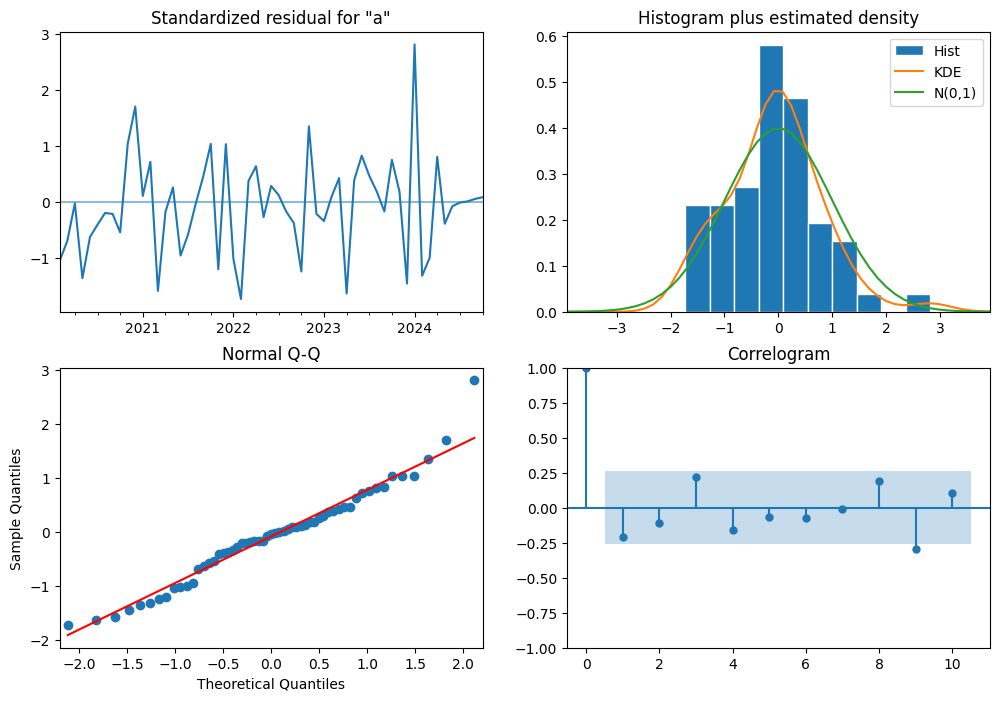

In [48]:
# Plot diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.show()

C:\Users\zygim\AppData\Local\Temp\ipykernel_9636\1364037899.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=sarima_df.index[-1], periods=37, freq='M')[1:]


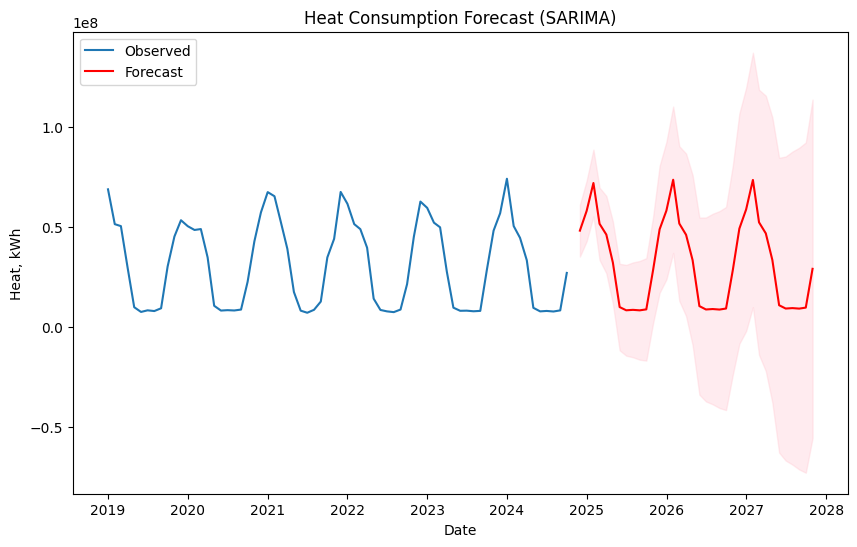

In [49]:
# Forecast 12 months ahead
forecast = results.get_forecast(steps=36)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create future dates
future_dates = pd.date_range(start=sarima_df.index[-1], periods=37, freq='M')[1:]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sarima_df['amount'], label='Observed')
plt.plot(future_dates, forecast_mean, label='Forecast', color='red')
plt.fill_between(future_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Heat Consumption Forecast (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Heat, kWh')
plt.legend()
plt.show()
# Print forecast values
forecast_df = pd.DataFrame({'Forecast': forecast_mean}, index=future_dates)


In [50]:
import itertools

p = d = q = P = D = Q = [0, 1]
s = 12
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in pdq]

best_aic = float('inf')
best_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(sarima_df['amount'], order=param, seasonal_order=param_seasonal)
            res = mod.fit(disp=False)
            if res.aic < best_aic:
                best_aic = res.aic
                best_params = (param, param_seasonal)
        except:
            continue

print(f'Best AIC: {best_aic}, Best Params: {best_params}')

z:\projects\python\personal\siluma\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
z:\projects\python\personal\siluma\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
z:\projects\python\personal\siluma\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
z:\projects\python\personal\siluma\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
z:\projects\python\personal\siluma\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: 

Best AIC: 1945.5358025988319, Best Params: ((0, 1, 1), (1, 1, 0, 12))
